# Convolutional Neural Network

This example shows how to design a simple CNN.

We also show the impact of quantization on accuracy and lastly how to run the model in FHE.

### Import required modules

In [1]:
import time

import numpy as np
import torch
import torch.utils
from concrete.compiler import check_gpu_available
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

### Load the data-set and visualize it

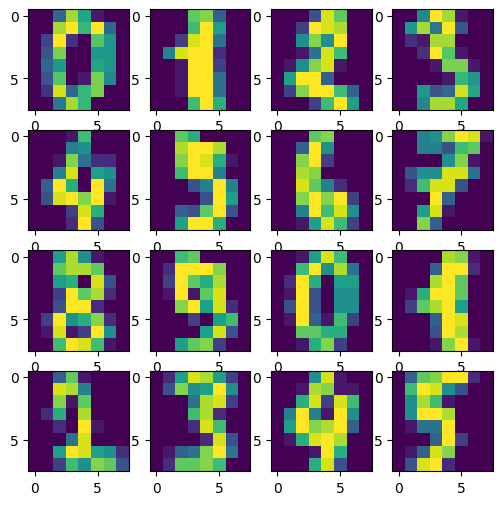

In [2]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits data-set, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

### Define the neural network

In [3]:
class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits data-set."""

    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        # This network has a total complexity of 1216 MAC
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, 2, stride=1, padding=0)
        self.fc1 = nn.Linear(32, n_classes)

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

### Train the CNN

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   1%|          | 1/150 [00:00<00:19,  7.58it/s]

Training:   1%|▏         | 2/150 [00:00<00:18,  7.82it/s]

Training:   2%|▏         | 3/150 [00:00<00:18,  7.83it/s]

Training:   3%|▎         | 4/150 [00:00<00:18,  7.85it/s]

Training:   3%|▎         | 5/150 [00:00<00:18,  7.97it/s]

Training:   4%|▍         | 6/150 [00:00<00:17,  8.04it/s]

Training:   5%|▍         | 7/150 [00:00<00:17,  8.08it/s]

Training:   5%|▌         | 8/150 [00:00<00:17,  8.13it/s]

Training:   6%|▌         | 9/150 [00:01<00:17,  8.19it/s]

Training:   7%|▋         | 10/150 [00:01<00:17,  8.23it/s]

Training:   7%|▋         | 11/150 [00:01<00:16,  8.27it/s]

Training:   8%|▊         | 12/150 [00:01<00:16,  8.30it/s]

Training:   9%|▊         | 13/150 [00:01<00:16,  8.30it/s]

Training:   9%|▉         | 14/150 [00:01<00:16,  8.31it/s]

Training:  10%|█         | 15/150 [00:01<00:16,  8.12it/s]

Training:  11%|█         | 16/150 [00:01<00:16,  8.17it/s]

Training:  11%|█▏        | 17/150 [00:02<00:16,  8.22it/s]

Training:  12%|█▏        | 18/150 [00:02<00:16,  8.24it/s]

Training:  13%|█▎        | 19/150 [00:02<00:16,  8.18it/s]

Training:  13%|█▎        | 20/150 [00:02<00:15,  8.21it/s]

Training:  14%|█▍        | 21/150 [00:02<00:15,  8.25it/s]

Training:  15%|█▍        | 22/150 [00:02<00:15,  8.03it/s]

Training:  15%|█▌        | 23/150 [00:02<00:16,  7.89it/s]

Training:  16%|█▌        | 24/150 [00:02<00:16,  7.84it/s]

Training:  17%|█▋        | 25/150 [00:03<00:15,  7.87it/s]

Training:  17%|█▋        | 26/150 [00:03<00:15,  7.85it/s]

Training:  18%|█▊        | 27/150 [00:03<00:15,  7.82it/s]

Training:  19%|█▊        | 28/150 [00:03<00:15,  7.82it/s]

Training:  19%|█▉        | 29/150 [00:03<00:15,  7.84it/s]

Training:  20%|██        | 30/150 [00:03<00:15,  7.87it/s]

Training:  21%|██        | 31/150 [00:03<00:15,  7.85it/s]

Training:  21%|██▏       | 32/150 [00:03<00:14,  7.89it/s]

Training:  22%|██▏       | 33/150 [00:04<00:14,  7.92it/s]

Training:  23%|██▎       | 34/150 [00:04<00:14,  7.92it/s]

Training:  23%|██▎       | 35/150 [00:04<00:14,  7.92it/s]

Training:  24%|██▍       | 36/150 [00:04<00:14,  7.94it/s]

Training:  25%|██▍       | 37/150 [00:04<00:14,  7.96it/s]

Training:  25%|██▌       | 38/150 [00:04<00:14,  7.93it/s]

Training:  26%|██▌       | 39/150 [00:04<00:13,  7.93it/s]

Training:  27%|██▋       | 40/150 [00:04<00:13,  7.93it/s]

Training:  27%|██▋       | 41/150 [00:05<00:13,  7.91it/s]

Training:  28%|██▊       | 42/150 [00:05<00:13,  7.89it/s]

Training:  29%|██▊       | 43/150 [00:05<00:13,  7.89it/s]

Training:  29%|██▉       | 44/150 [00:05<00:13,  7.90it/s]

Training:  30%|███       | 45/150 [00:05<00:13,  7.95it/s]

Training:  31%|███       | 46/150 [00:05<00:13,  7.95it/s]

Training:  31%|███▏      | 47/150 [00:05<00:13,  7.92it/s]

Training:  32%|███▏      | 48/150 [00:06<00:12,  7.96it/s]

Training:  33%|███▎      | 49/150 [00:06<00:12,  7.92it/s]

Training:  33%|███▎      | 50/150 [00:06<00:12,  7.93it/s]

Training:  34%|███▍      | 51/150 [00:06<00:12,  7.94it/s]

Training:  35%|███▍      | 52/150 [00:06<00:12,  7.97it/s]

Training:  35%|███▌      | 53/150 [00:06<00:12,  7.99it/s]

Training:  36%|███▌      | 54/150 [00:06<00:12,  7.99it/s]

Training:  37%|███▋      | 55/150 [00:06<00:11,  7.93it/s]

Training:  37%|███▋      | 56/150 [00:07<00:11,  7.94it/s]

Training:  38%|███▊      | 57/150 [00:07<00:11,  7.86it/s]

Training:  39%|███▊      | 58/150 [00:07<00:11,  7.87it/s]

Training:  39%|███▉      | 59/150 [00:07<00:11,  7.88it/s]

Training:  40%|████      | 60/150 [00:07<00:11,  7.88it/s]

Training:  41%|████      | 61/150 [00:07<00:11,  7.88it/s]

Training:  41%|████▏     | 62/150 [00:07<00:11,  7.90it/s]

Training:  42%|████▏     | 63/150 [00:07<00:11,  7.75it/s]

Training:  43%|████▎     | 64/150 [00:08<00:11,  7.78it/s]

Training:  43%|████▎     | 65/150 [00:08<00:10,  7.81it/s]

Training:  44%|████▍     | 66/150 [00:08<00:10,  7.82it/s]

Training:  45%|████▍     | 67/150 [00:08<00:10,  7.84it/s]

Training:  45%|████▌     | 68/150 [00:08<00:10,  7.87it/s]

Training:  46%|████▌     | 69/150 [00:08<00:10,  7.84it/s]

Training:  47%|████▋     | 70/150 [00:08<00:10,  7.79it/s]

Training:  47%|████▋     | 71/150 [00:08<00:10,  7.73it/s]

Training:  48%|████▊     | 72/150 [00:09<00:10,  7.75it/s]

Training:  49%|████▊     | 73/150 [00:09<00:09,  7.82it/s]

Training:  49%|████▉     | 74/150 [00:09<00:09,  7.86it/s]

Training:  50%|█████     | 75/150 [00:09<00:09,  7.88it/s]

Training:  51%|█████     | 76/150 [00:09<00:09,  7.90it/s]

Training:  51%|█████▏    | 77/150 [00:09<00:09,  7.91it/s]

Training:  52%|█████▏    | 78/150 [00:09<00:09,  7.93it/s]

Training:  53%|█████▎    | 79/150 [00:09<00:08,  7.94it/s]

Training:  53%|█████▎    | 80/150 [00:10<00:08,  7.92it/s]

Training:  54%|█████▍    | 81/150 [00:10<00:08,  7.92it/s]

Training:  55%|█████▍    | 82/150 [00:10<00:08,  7.91it/s]

Training:  55%|█████▌    | 83/150 [00:10<00:08,  7.92it/s]

Training:  56%|█████▌    | 84/150 [00:10<00:08,  7.94it/s]

Training:  57%|█████▋    | 85/150 [00:10<00:08,  7.95it/s]

Training:  57%|█████▋    | 86/150 [00:10<00:08,  7.88it/s]

Training:  58%|█████▊    | 87/150 [00:10<00:07,  7.88it/s]

Training:  59%|█████▊    | 88/150 [00:11<00:07,  7.92it/s]

Training:  59%|█████▉    | 89/150 [00:11<00:07,  7.94it/s]

Training:  60%|██████    | 90/150 [00:11<00:07,  7.92it/s]

Training:  61%|██████    | 91/150 [00:11<00:07,  7.96it/s]

Training:  61%|██████▏   | 92/150 [00:11<00:07,  7.96it/s]

Training:  62%|██████▏   | 93/150 [00:11<00:07,  7.96it/s]

Training:  63%|██████▎   | 94/150 [00:11<00:07,  7.94it/s]

Training:  63%|██████▎   | 95/150 [00:11<00:06,  7.92it/s]

Training:  64%|██████▍   | 96/150 [00:12<00:06,  7.90it/s]

Training:  65%|██████▍   | 97/150 [00:12<00:06,  7.93it/s]

Training:  65%|██████▌   | 98/150 [00:12<00:06,  7.95it/s]

Training:  66%|██████▌   | 99/150 [00:12<00:06,  7.95it/s]

Training:  67%|██████▋   | 100/150 [00:12<00:06,  7.94it/s]

Training:  67%|██████▋   | 101/150 [00:12<00:06,  7.96it/s]

Training:  68%|██████▊   | 102/150 [00:12<00:06,  7.94it/s]

Training:  69%|██████▊   | 103/150 [00:12<00:05,  7.91it/s]

Training:  69%|██████▉   | 104/150 [00:13<00:05,  7.89it/s]

Training:  70%|███████   | 105/150 [00:13<00:05,  7.90it/s]

Training:  71%|███████   | 106/150 [00:13<00:05,  7.89it/s]

Training:  71%|███████▏  | 107/150 [00:13<00:05,  7.91it/s]

Training:  72%|███████▏  | 108/150 [00:13<00:05,  7.92it/s]

Training:  73%|███████▎  | 109/150 [00:13<00:05,  7.92it/s]

Training:  73%|███████▎  | 110/150 [00:13<00:05,  7.86it/s]

Training:  74%|███████▍  | 111/150 [00:13<00:04,  8.00it/s]

Training:  75%|███████▍  | 112/150 [00:14<00:04,  8.02it/s]

Training:  75%|███████▌  | 113/150 [00:14<00:04,  8.02it/s]

Training:  76%|███████▌  | 114/150 [00:14<00:04,  8.01it/s]

Training:  77%|███████▋  | 115/150 [00:14<00:04,  8.04it/s]

Training:  77%|███████▋  | 116/150 [00:14<00:04,  8.00it/s]

Training:  78%|███████▊  | 117/150 [00:14<00:04,  7.96it/s]

Training:  79%|███████▊  | 118/150 [00:14<00:04,  7.91it/s]

Training:  79%|███████▉  | 119/150 [00:14<00:03,  7.92it/s]

Training:  80%|████████  | 120/150 [00:15<00:03,  7.94it/s]

Training:  81%|████████  | 121/150 [00:15<00:03,  7.94it/s]

Training:  81%|████████▏ | 122/150 [00:15<00:03,  7.98it/s]

Training:  82%|████████▏ | 123/150 [00:15<00:03,  7.99it/s]

Training:  83%|████████▎ | 124/150 [00:15<00:03,  7.97it/s]

Training:  83%|████████▎ | 125/150 [00:15<00:03,  7.94it/s]

Training:  84%|████████▍ | 126/150 [00:15<00:03,  7.92it/s]

Training:  85%|████████▍ | 127/150 [00:15<00:02,  7.93it/s]

Training:  85%|████████▌ | 128/150 [00:16<00:02,  8.04it/s]

Training:  86%|████████▌ | 129/150 [00:16<00:02,  8.04it/s]

Training:  87%|████████▋ | 130/150 [00:16<00:02,  8.02it/s]

Training:  87%|████████▋ | 131/150 [00:16<00:02,  8.03it/s]

Training:  88%|████████▊ | 132/150 [00:16<00:02,  7.97it/s]

Training:  89%|████████▊ | 133/150 [00:16<00:02,  7.96it/s]

Training:  89%|████████▉ | 134/150 [00:16<00:02,  7.94it/s]

Training:  90%|█████████ | 135/150 [00:16<00:01,  7.95it/s]

Training:  91%|█████████ | 136/150 [00:17<00:01,  7.95it/s]

Training:  91%|█████████▏| 137/150 [00:17<00:01,  7.94it/s]

Training:  92%|█████████▏| 138/150 [00:17<00:01,  7.92it/s]

Training:  93%|█████████▎| 139/150 [00:17<00:01,  7.95it/s]

Training:  93%|█████████▎| 140/150 [00:17<00:01,  7.93it/s]

Training:  94%|█████████▍| 141/150 [00:17<00:01,  7.94it/s]

Training:  95%|█████████▍| 142/150 [00:17<00:01,  7.90it/s]

Training:  95%|█████████▌| 143/150 [00:17<00:00,  7.94it/s]

Training:  96%|█████████▌| 144/150 [00:18<00:00,  7.95it/s]

Training:  97%|█████████▋| 145/150 [00:18<00:00,  7.93it/s]

Training:  97%|█████████▋| 146/150 [00:18<00:00,  7.95it/s]

Training:  98%|█████████▊| 147/150 [00:18<00:00,  7.95it/s]

Training:  99%|█████████▊| 148/150 [00:18<00:00,  7.96it/s]

Training:  99%|█████████▉| 149/150 [00:18<00:00,  7.95it/s]

Training: 100%|██████████| 150/150 [00:18<00:00,  7.93it/s]

Training: 100%|██████████| 150/150 [00:18<00:00,  7.95it/s]

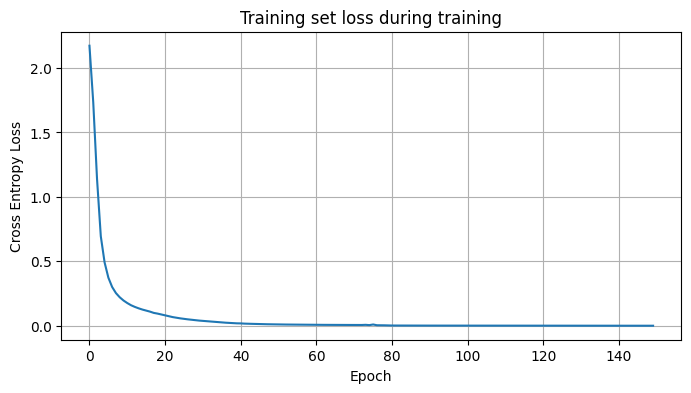

In [4]:
torch.manual_seed(42)


def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
N_EPOCHS = 150

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

# Train the network with Adam, output the test set accuracy every epoch
net = TinyCNN(10)
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

### Test the torch network in fp32

In [5]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for fp32 weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


test_torch(net, test_dataloader)

Test accuracy for fp32 weights and activations: 98.22%


### Define the Concrete ML testing function

We introduce the `test_with_concrete` function which allows us to test a Concrete ML model in one of two modes:
- in FHE
- in the clear, using simulated FHE execution

Note that it is trivial to toggle between between the two modes. 

In [6]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

### Test the network using Simulation

Note that this is not a test in FHE. The simulated FHE mode gives 
insight about the impact of FHE execution on the accuracy.

The torch neural network is converted to FHE by Concrete ML using a dedicated function, `compile_torch_model`.

In [7]:
n_bits = 6

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"

q_module = compile_torch_model(net, x_train, rounding_threshold_bits=6, p_error=0.1, device=device)

start_time = time.time()
accs = test_with_concrete(
    q_module,
    test_dataloader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

  0%|          | 0/450 [00:00<?, ?it/s]

  0%|          | 1/450 [00:00<03:13,  2.32it/s]

  1%|          | 3/450 [00:00<01:14,  6.04it/s]

  1%|▏         | 6/450 [00:00<00:38, 11.64it/s]

  2%|▏         | 9/450 [00:00<00:27, 16.03it/s]

  3%|▎         | 12/450 [00:00<00:22, 19.30it/s]

  3%|▎         | 15/450 [00:01<00:19, 21.77it/s]

  4%|▍         | 18/450 [00:01<00:18, 23.58it/s]

  5%|▍         | 21/450 [00:01<00:17, 24.91it/s]

  5%|▌         | 24/450 [00:01<00:16, 25.84it/s]

  6%|▌         | 27/450 [00:01<00:15, 26.54it/s]

  7%|▋         | 30/450 [00:01<00:15, 27.01it/s]

  7%|▋         | 33/450 [00:01<00:15, 27.34it/s]

  8%|▊         | 36/450 [00:01<00:15, 27.57it/s]

  9%|▊         | 39/450 [00:01<00:14, 27.72it/s]

  9%|▉         | 42/450 [00:01<00:14, 27.82it/s]

 10%|█         | 45/450 [00:02<00:14, 27.93it/s]

 11%|█         | 48/450 [00:02<00:14, 28.01it/s]

 11%|█▏        | 51/450 [00:02<00:14, 28.07it/s]

 12%|█▏        | 54/450 [00:02<00:14, 28.12it/s]

 13%|█▎        | 57/450 [00:02<00:13, 28.13it/s]

 13%|█▎        | 60/450 [00:02<00:13, 28.12it/s]

 14%|█▍        | 63/450 [00:02<00:13, 28.09it/s]

 15%|█▍        | 66/450 [00:02<00:13, 28.10it/s]

 15%|█▌        | 69/450 [00:02<00:13, 28.12it/s]

 16%|█▌        | 72/450 [00:03<00:13, 28.15it/s]

 17%|█▋        | 75/450 [00:03<00:13, 28.17it/s]

 17%|█▋        | 78/450 [00:03<00:13, 28.16it/s]

 18%|█▊        | 81/450 [00:03<00:13, 28.21it/s]

 19%|█▊        | 84/450 [00:03<00:12, 28.17it/s]

 19%|█▉        | 87/450 [00:03<00:13, 27.82it/s]

 20%|██        | 90/450 [00:03<00:12, 27.95it/s]

 21%|██        | 93/450 [00:03<00:12, 28.01it/s]

 21%|██▏       | 96/450 [00:03<00:12, 28.05it/s]

 22%|██▏       | 99/450 [00:03<00:12, 28.11it/s]

 23%|██▎       | 102/450 [00:04<00:12, 28.14it/s]

 23%|██▎       | 105/450 [00:04<00:12, 28.10it/s]

 24%|██▍       | 108/450 [00:04<00:12, 28.13it/s]

 25%|██▍       | 111/450 [00:04<00:12, 28.20it/s]

 25%|██▌       | 114/450 [00:04<00:11, 28.21it/s]

 26%|██▌       | 117/450 [00:04<00:11, 28.25it/s]

 27%|██▋       | 120/450 [00:04<00:11, 28.41it/s]

 27%|██▋       | 123/450 [00:04<00:11, 28.41it/s]

 28%|██▊       | 126/450 [00:04<00:11, 28.45it/s]

 29%|██▊       | 129/450 [00:05<00:11, 28.57it/s]

 29%|██▉       | 132/450 [00:05<00:11, 28.56it/s]

 30%|███       | 135/450 [00:05<00:11, 28.54it/s]

 31%|███       | 138/450 [00:05<00:10, 28.65it/s]

 31%|███▏      | 141/450 [00:05<00:10, 28.70it/s]

 32%|███▏      | 144/450 [00:05<00:10, 28.66it/s]

 33%|███▎      | 147/450 [00:05<00:10, 28.75it/s]

 33%|███▎      | 150/450 [00:05<00:10, 28.85it/s]

 34%|███▍      | 153/450 [00:05<00:10, 28.90it/s]

 35%|███▍      | 156/450 [00:05<00:10, 28.91it/s]

 35%|███▌      | 159/450 [00:06<00:10, 28.91it/s]

 36%|███▌      | 162/450 [00:06<00:09, 28.93it/s]

 37%|███▋      | 165/450 [00:06<00:09, 28.94it/s]

 37%|███▋      | 168/450 [00:06<00:09, 28.92it/s]

 38%|███▊      | 171/450 [00:06<00:09, 28.91it/s]

 39%|███▊      | 174/450 [00:06<00:09, 28.91it/s]

 39%|███▉      | 177/450 [00:06<00:09, 28.94it/s]

 40%|████      | 180/450 [00:06<00:09, 28.95it/s]

 41%|████      | 183/450 [00:06<00:09, 28.96it/s]

 41%|████▏     | 186/450 [00:07<00:09, 28.84it/s]

 42%|████▏     | 189/450 [00:07<00:09, 28.85it/s]

 43%|████▎     | 192/450 [00:07<00:08, 28.88it/s]

 43%|████▎     | 195/450 [00:07<00:08, 28.91it/s]

 44%|████▍     | 198/450 [00:07<00:08, 28.92it/s]

 45%|████▍     | 201/450 [00:07<00:08, 28.93it/s]

 45%|████▌     | 204/450 [00:07<00:08, 28.95it/s]

 46%|████▌     | 207/450 [00:07<00:08, 28.96it/s]

 47%|████▋     | 210/450 [00:07<00:08, 28.98it/s]

 47%|████▋     | 213/450 [00:07<00:08, 28.99it/s]

 48%|████▊     | 216/450 [00:08<00:08, 28.98it/s]

 49%|████▊     | 219/450 [00:08<00:07, 29.04it/s]

 49%|████▉     | 222/450 [00:08<00:07, 29.16it/s]

 50%|█████     | 225/450 [00:08<00:07, 29.24it/s]

 51%|█████     | 228/450 [00:08<00:07, 29.29it/s]

 51%|█████▏    | 231/450 [00:08<00:07, 29.33it/s]

 52%|█████▏    | 234/450 [00:08<00:07, 29.35it/s]

 53%|█████▎    | 237/450 [00:08<00:07, 29.38it/s]

 53%|█████▎    | 240/450 [00:08<00:07, 29.40it/s]

 54%|█████▍    | 243/450 [00:08<00:07, 29.42it/s]

 55%|█████▍    | 246/450 [00:09<00:06, 29.43it/s]

 55%|█████▌    | 249/450 [00:09<00:06, 29.43it/s]

 56%|█████▌    | 252/450 [00:09<00:06, 29.43it/s]

 57%|█████▋    | 255/450 [00:09<00:06, 29.42it/s]

 57%|█████▋    | 258/450 [00:09<00:06, 29.43it/s]

 58%|█████▊    | 261/450 [00:09<00:06, 29.43it/s]

 59%|█████▊    | 264/450 [00:09<00:06, 29.42it/s]

 59%|█████▉    | 267/450 [00:09<00:06, 29.42it/s]

 60%|██████    | 270/450 [00:09<00:06, 29.42it/s]

 61%|██████    | 273/450 [00:09<00:06, 29.42it/s]

 61%|██████▏   | 276/450 [00:10<00:05, 29.39it/s]

 62%|██████▏   | 279/450 [00:10<00:05, 29.38it/s]

 63%|██████▎   | 282/450 [00:10<00:05, 29.40it/s]

 63%|██████▎   | 285/450 [00:10<00:05, 29.41it/s]

 64%|██████▍   | 288/450 [00:10<00:05, 29.40it/s]

 65%|██████▍   | 291/450 [00:10<00:05, 29.40it/s]

 65%|██████▌   | 294/450 [00:10<00:05, 29.41it/s]

 66%|██████▌   | 297/450 [00:10<00:05, 29.41it/s]

 67%|██████▋   | 300/450 [00:10<00:05, 29.41it/s]

 67%|██████▋   | 303/450 [00:11<00:04, 29.42it/s]

 68%|██████▊   | 306/450 [00:11<00:04, 29.41it/s]

 69%|██████▊   | 309/450 [00:11<00:04, 29.41it/s]

 69%|██████▉   | 312/450 [00:11<00:04, 29.42it/s]

 70%|███████   | 315/450 [00:11<00:04, 29.41it/s]

 71%|███████   | 318/450 [00:11<00:04, 29.42it/s]

 71%|███████▏  | 321/450 [00:11<00:04, 29.41it/s]

 72%|███████▏  | 324/450 [00:11<00:04, 29.41it/s]

 73%|███████▎  | 327/450 [00:11<00:04, 29.42it/s]

 73%|███████▎  | 330/450 [00:11<00:04, 29.43it/s]

 74%|███████▍  | 333/450 [00:12<00:03, 29.43it/s]

 75%|███████▍  | 336/450 [00:12<00:03, 29.40it/s]

 75%|███████▌  | 339/450 [00:12<00:03, 29.39it/s]

 76%|███████▌  | 342/450 [00:12<00:03, 29.40it/s]

 77%|███████▋  | 345/450 [00:12<00:03, 29.41it/s]

 77%|███████▋  | 348/450 [00:12<00:03, 29.42it/s]

 78%|███████▊  | 351/450 [00:12<00:03, 29.41it/s]

 79%|███████▊  | 354/450 [00:12<00:03, 29.43it/s]

 79%|███████▉  | 357/450 [00:12<00:03, 29.43it/s]

 80%|████████  | 360/450 [00:12<00:03, 29.45it/s]

 81%|████████  | 363/450 [00:13<00:02, 29.45it/s]

 81%|████████▏ | 366/450 [00:13<00:02, 29.44it/s]

 82%|████████▏ | 369/450 [00:13<00:02, 29.44it/s]

 83%|████████▎ | 372/450 [00:13<00:02, 29.44it/s]

 83%|████████▎ | 375/450 [00:13<00:02, 29.43it/s]

 84%|████████▍ | 378/450 [00:13<00:02, 29.43it/s]

 85%|████████▍ | 381/450 [00:13<00:02, 28.83it/s]

 85%|████████▌ | 384/450 [00:13<00:02, 29.00it/s]

 86%|████████▌ | 387/450 [00:13<00:02, 29.14it/s]

 87%|████████▋ | 390/450 [00:13<00:02, 29.23it/s]

 87%|████████▋ | 393/450 [00:14<00:01, 29.29it/s]

 88%|████████▊ | 396/450 [00:14<00:01, 29.34it/s]

 89%|████████▊ | 399/450 [00:14<00:01, 29.34it/s]

 89%|████████▉ | 402/450 [00:14<00:01, 29.37it/s]

 90%|█████████ | 405/450 [00:14<00:01, 29.39it/s]

 91%|█████████ | 408/450 [00:14<00:01, 29.40it/s]

 91%|█████████▏| 411/450 [00:14<00:01, 29.41it/s]

 92%|█████████▏| 414/450 [00:14<00:01, 29.42it/s]

 93%|█████████▎| 417/450 [00:14<00:01, 29.42it/s]

 93%|█████████▎| 420/450 [00:15<00:01, 29.42it/s]

 94%|█████████▍| 423/450 [00:15<00:00, 29.42it/s]

 95%|█████████▍| 426/450 [00:15<00:00, 29.43it/s]

 95%|█████████▌| 429/450 [00:15<00:00, 29.44it/s]

 96%|█████████▌| 432/450 [00:15<00:00, 29.42it/s]

 97%|█████████▋| 435/450 [00:15<00:00, 29.44it/s]

 97%|█████████▋| 438/450 [00:15<00:00, 29.43it/s]

 98%|█████████▊| 441/450 [00:15<00:00, 29.44it/s]

 99%|█████████▊| 444/450 [00:15<00:00, 29.44it/s]

 99%|█████████▉| 447/450 [00:15<00:00, 29.45it/s]

100%|██████████| 450/450 [00:16<00:00, 29.45it/s]

100%|██████████| 450/450 [00:16<00:00, 28.09it/s]

Simulated FHE execution for 6 bit network accuracy: 0.97%


### Generate Keys

In [8]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 1.88s

### 3. Execute in FHE on encrypted data

In [9]:
# Run inference in FHE on a single encrypted example
mini_test_dataset = TensorDataset(torch.Tensor(x_test[:100, :]), torch.Tensor(y_test[:100]))
mini_test_dataloader = DataLoader(mini_test_dataset)

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    mini_test_dataloader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(mini_test_dataset)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:02<04:29,  2.73s/it]

  2%|▏         | 2/100 [00:04<03:55,  2.41s/it]

  3%|▎         | 3/100 [00:14<08:51,  5.48s/it]

  4%|▍         | 4/100 [00:18<07:51,  4.91s/it]

  5%|▌         | 5/100 [00:20<06:14,  3.95s/it]

  6%|▌         | 6/100 [00:22<05:19,  3.40s/it]

  7%|▋         | 7/100 [00:24<04:40,  3.02s/it]

  8%|▊         | 8/100 [00:27<04:14,  2.76s/it]

  9%|▉         | 9/100 [00:31<05:07,  3.38s/it]

 10%|█         | 10/100 [00:36<05:34,  3.72s/it]

 11%|█         | 11/100 [00:38<04:53,  3.29s/it]

 12%|█▏        | 12/100 [00:41<04:25,  3.02s/it]

 13%|█▎        | 13/100 [00:43<04:03,  2.80s/it]

 14%|█▍        | 14/100 [00:45<03:47,  2.65s/it]

 15%|█▌        | 15/100 [00:47<03:35,  2.53s/it]

 16%|█▌        | 16/100 [00:50<03:25,  2.45s/it]

 17%|█▋        | 17/100 [00:52<03:18,  2.40s/it]

 18%|█▊        | 18/100 [00:54<03:13,  2.36s/it]

 19%|█▉        | 19/100 [00:58<03:47,  2.81s/it]

 20%|██        | 20/100 [01:00<03:35,  2.69s/it]

 21%|██        | 21/100 [01:04<03:57,  3.00s/it]

 22%|██▏       | 22/100 [01:08<04:12,  3.24s/it]

 23%|██▎       | 23/100 [01:10<03:47,  2.95s/it]

 24%|██▍       | 24/100 [01:13<03:28,  2.75s/it]

 25%|██▌       | 25/100 [01:15<03:17,  2.63s/it]

 26%|██▌       | 26/100 [01:17<03:06,  2.52s/it]

 27%|██▋       | 27/100 [01:19<02:58,  2.44s/it]

 28%|██▊       | 28/100 [01:22<02:51,  2.38s/it]

 29%|██▉       | 29/100 [01:24<02:46,  2.35s/it]

 30%|███       | 30/100 [01:26<02:42,  2.32s/it]

 31%|███       | 31/100 [01:28<02:38,  2.30s/it]

 32%|███▏      | 32/100 [01:32<02:53,  2.56s/it]

 33%|███▎      | 33/100 [01:34<02:45,  2.47s/it]

 34%|███▍      | 34/100 [01:36<02:39,  2.41s/it]

 35%|███▌      | 35/100 [01:41<03:25,  3.16s/it]

 36%|███▌      | 36/100 [01:43<03:05,  2.89s/it]

 37%|███▋      | 37/100 [01:46<02:49,  2.70s/it]

 38%|███▊      | 38/100 [01:48<02:38,  2.56s/it]

 39%|███▉      | 39/100 [01:52<02:57,  2.91s/it]

 40%|████      | 40/100 [01:54<02:43,  2.73s/it]

 41%|████      | 41/100 [01:56<02:32,  2.59s/it]

 42%|████▏     | 42/100 [01:58<02:24,  2.49s/it]

 43%|████▎     | 43/100 [02:01<02:17,  2.42s/it]

 44%|████▍     | 44/100 [02:04<02:26,  2.62s/it]

 45%|████▌     | 45/100 [02:06<02:18,  2.51s/it]

 46%|████▌     | 46/100 [02:08<02:11,  2.44s/it]

 47%|████▋     | 47/100 [02:10<02:06,  2.38s/it]

 48%|████▊     | 48/100 [02:14<02:15,  2.61s/it]

 49%|████▉     | 49/100 [02:16<02:12,  2.61s/it]

 50%|█████     | 50/100 [02:19<02:09,  2.59s/it]

 51%|█████     | 51/100 [02:22<02:09,  2.64s/it]

 52%|█████▏    | 52/100 [02:24<02:00,  2.52s/it]

 53%|█████▎    | 53/100 [02:26<01:54,  2.43s/it]

 54%|█████▍    | 54/100 [02:28<01:49,  2.38s/it]

 55%|█████▌    | 55/100 [02:30<01:45,  2.34s/it]

 56%|█████▌    | 56/100 [02:33<01:41,  2.31s/it]

 57%|█████▋    | 57/100 [02:35<01:39,  2.32s/it]

 58%|█████▊    | 58/100 [02:37<01:36,  2.30s/it]

 59%|█████▉    | 59/100 [02:40<01:33,  2.29s/it]

 60%|██████    | 60/100 [02:42<01:31,  2.29s/it]

 61%|██████    | 61/100 [02:44<01:29,  2.29s/it]

 62%|██████▏   | 62/100 [02:46<01:26,  2.28s/it]

 63%|██████▎   | 63/100 [02:49<01:24,  2.27s/it]

 64%|██████▍   | 64/100 [02:51<01:21,  2.27s/it]

 65%|██████▌   | 65/100 [02:53<01:19,  2.26s/it]

 66%|██████▌   | 66/100 [02:55<01:16,  2.25s/it]

 67%|██████▋   | 67/100 [02:58<01:14,  2.25s/it]

 68%|██████▊   | 68/100 [03:00<01:12,  2.26s/it]

 69%|██████▉   | 69/100 [03:02<01:10,  2.26s/it]

 70%|███████   | 70/100 [03:05<01:08,  2.28s/it]

 71%|███████   | 71/100 [03:07<01:05,  2.27s/it]

 72%|███████▏  | 72/100 [03:09<01:03,  2.27s/it]

 73%|███████▎  | 73/100 [03:12<01:10,  2.61s/it]

 74%|███████▍  | 74/100 [03:15<01:05,  2.53s/it]

 75%|███████▌  | 75/100 [03:17<01:01,  2.45s/it]

 76%|███████▌  | 76/100 [03:19<00:57,  2.39s/it]

 77%|███████▋  | 77/100 [03:22<00:54,  2.35s/it]

 78%|███████▊  | 78/100 [03:24<00:51,  2.34s/it]

 79%|███████▉  | 79/100 [03:26<00:48,  2.32s/it]

 80%|████████  | 80/100 [03:28<00:45,  2.30s/it]

 81%|████████  | 81/100 [03:31<00:43,  2.28s/it]

 82%|████████▏ | 82/100 [03:33<00:43,  2.44s/it]

 83%|████████▎ | 83/100 [03:36<00:40,  2.40s/it]

 84%|████████▍ | 84/100 [03:38<00:38,  2.42s/it]

 85%|████████▌ | 85/100 [03:40<00:35,  2.38s/it]

 86%|████████▌ | 86/100 [03:44<00:35,  2.57s/it]

 87%|████████▋ | 87/100 [03:46<00:32,  2.48s/it]

 88%|████████▊ | 88/100 [03:48<00:28,  2.41s/it]

 89%|████████▉ | 89/100 [03:50<00:25,  2.36s/it]

 90%|█████████ | 90/100 [03:53<00:23,  2.38s/it]

 91%|█████████ | 91/100 [03:55<00:21,  2.34s/it]

 92%|█████████▏| 92/100 [03:57<00:18,  2.31s/it]

 93%|█████████▎| 93/100 [03:59<00:16,  2.30s/it]

 94%|█████████▍| 94/100 [04:02<00:13,  2.29s/it]

 95%|█████████▌| 95/100 [04:04<00:11,  2.28s/it]

 96%|█████████▌| 96/100 [04:06<00:09,  2.27s/it]

 97%|█████████▋| 97/100 [04:08<00:06,  2.27s/it]

 98%|█████████▊| 98/100 [04:11<00:04,  2.26s/it]

 99%|█████████▉| 99/100 [04:13<00:02,  2.26s/it]

100%|██████████| 100/100 [04:15<00:00,  2.26s/it]

100%|██████████| 100/100 [04:15<00:00,  2.56s/it]

Time per inference in FHE: 2.56 with 99.00% accuracy


### Conclusion

In this example, a simple CNN model is trained with torch and reach 99% accuracy in clear. The model is then converted to FHE and evaluated over 100 samples in FHE.

The model in FHE achieves **the same accuracy** as the original torch model with a FHE execution time of **2.9 seconds** per image.